In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision = 3, suppress = True)

### Параметри для генерування часового ряду або читання даних з файлів

In [2]:
READ_FROM_FILE = False

if READ_FROM_FILE:
    a, b = [], []
    with open('./test.txt') as fin:
        for line in fin:
            coef = line.strip().split('=')
            if coef[0].startswith('a'):
                a.append(float(coef[1]))
            if coef[0].startswith('b'):
                b.append(float(coef[1]))
    y = np.loadtxt('./y.txt')
    v = np.loadtxt('./v.txt')
    gen_order = (len(a), len(b))
    N = len(y)
else:
    gen_order = (3, 3)          # порядок моделі
    a = [0, 0.22, -0.18, 0.08]  # коефіцієнти АР
    b = [0.5, 0.25, 0.25]       # коефіцієнти КС
    N = 100                     # кількість згенерованих значень

### Функція для генерування часового ряду

In [3]:
def make_series(a_coef, b_coef, order, n, mov_avg = None, noise_std = 0):
    if mov_avg is None:
        mov_avg = np.concatenate((
            np.random.randn(n+order[0]), np.zeros(order[1])
        ))
        RETURN_MA = True
    else:
        mov_avg = np.concatenate((
            mov_avg, np.zeros(order[1])
        ))
        RETURN_MA = False
    y = np.concatenate((
        a_coef[0]*np.ones(n+max(order)), np.zeros(order[0])
    ))
    for k in range(n+max(order)):
        y[k] += sum([
            a_coef[j]*y[k-j] for j in range(1, order[0]+1)
        ]) + mov_avg[k]
        y[k] += sum([
            b_coef[j-1]*mov_avg[k-j] for j in range(1, order[1]+1)
        ]) + np.random.randn()*noise_std
    if RETURN_MA:
        return y[max(order):-order[0]], mov_avg[:-order[1]]
    else:
        return y[max(order):-order[0]]

### Власне генерування часового ряду та його візуалізація

In [4]:
if not READ_FROM_FILE: 
    np.random.seed(42)
    y, v = make_series(a_coef = a, b_coef = b, 
                       order = gen_order, n = N,
                       noise_std = 0.5)

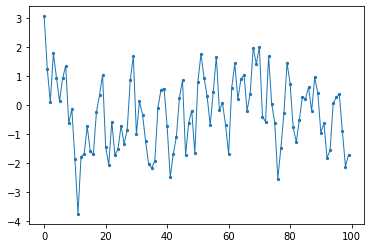

In [5]:
plt.plot(y, lw = 1)
plt.scatter(np.arange(N), y, s = 5)

### Функція для створення матриці спостережень X

In [6]:
def create_X(y, v, order = (3, 3)):
    N = min(len(y)-order[0], len(v)-order[1])
    X = np.zeros((N, 2+order[0]+order[1]))
    X[:, 0] = np.ones((N, ))
    for j in range(order[0]):
        X[:, order[0]-j] = y[j:N+j]
    for j in range(order[1]+1):
        X[:, order[0]+order[1]-j+1] = v[j+order[0]:N+j+order[0]]
    return X

### МНК

In [7]:
def LS(X, y):
    coefs_history = []
    for i in range(len(y)):
        X_temp = X[:i+1]
        y_temp = y[:i+1]
        coefs_history.append(
            np.linalg.pinv(X_temp.T @ X_temp) @ X_temp.T @ y_temp
        )
    return coefs_history

### РМНК

In [8]:
def RLS(X, y):
    n = X.shape[1]
    theta = np.zeros((n, 1))
    coefs_history = [theta.flatten()]
    P = 1e5 * np.eye(n)
    for i in range(len(y)):
        x = X[i].reshape((n, 1))
        temp = P @ x / (1 + x.T @ P @ x)
        theta += temp * (y[i] - x.T @ theta)
        coefs_history.append(theta.flatten())
        P = P - temp @ x.T @ P
    return coefs_history

### Функції для обчислення метрик моделі

In [9]:
# сума квадратів похибок
def sum_squared_error(y_true, y_pred):
    return ((y_true - y_pred)**2).sum()

# коефіцієнт детермінації R^2
def r_squared(y_true, y_pred):
    n = y_true.size
    return 1 - sum_squared_error(y_true, y_pred) / (n*y_true.var())

# значення критерію Акайке
def akaike(y_true, y_pred, ARMA):
    n = ARMA[0] + ARMA[1] +1
    N = y_true.size 
    return N * np.log(sum_squared_error(y_true,y_pred)) + 2*n

### Задання порядку моделі, яка буде шукатися

In [10]:
ARMA = (3, 2)

### Створення матриці X та вигляд її перших 5 рядків

In [11]:
X = create_X(y, v, ARMA)

In [12]:
X[:5]

array([[ 1.   ,  0.116,  1.261,  3.076, -0.234, -0.234,  1.523],
       [ 1.   ,  1.792,  0.116,  1.261,  1.579, -0.234, -0.234],
       [ 1.   ,  0.955,  1.792,  0.116,  0.767,  1.579, -0.234],
       [ 1.   ,  0.134,  0.955,  1.792, -0.469,  0.767,  1.579],
       [ 1.   ,  0.926,  0.134,  0.955,  0.543, -0.469,  0.767]])

### Знаходження коефіцієнтів за допомогою МНК та їх оцінювання

In [13]:
LS_history = LS(X, y[gen_order[0]:])
res_LS = LS_history[-1]
res_LS[ARMA[0]+1] = 1

In [14]:
res_LS

array([-0.157,  0.287, -0.079, -0.021,  1.   , -0.007,  0.208])

In [15]:
y_LS = make_series(a_coef = res_LS[:ARMA[0]+1], b_coef = res_LS[ARMA[0]+2:], 
                order = ARMA, n = N, mov_avg = v)

In [16]:
print('S =', sum_squared_error(y, y_LS))
print('R^2 =', r_squared(y, y_LS))
print('IKA =', akaike(y, y_LS, ARMA))

S = 50.18237989472593
R^2 = 0.6773020488520187
IKA = 403.56639669703986


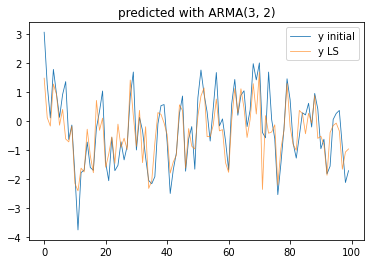

In [17]:
plt.plot(y, label = 'y initial', lw = 0.8)
plt.plot(y_LS, label = 'y LS', lw = 0.8, alpha = 0.7)
plt.title('predicted with ARMA' + f'{ARMA}')
plt.legend()

### Знаходження коефіцієнтів за допомогою РМНК та їх оцінювання

In [18]:
RLS_history = RLS(X, y[gen_order[0]:])
res_RLS = RLS_history[-1]
res_RLS[ARMA[0]+1] = 1

In [19]:
res_RLS

array([-0.157,  0.287, -0.079, -0.021,  1.   , -0.007,  0.208])

In [20]:
y_RLS = make_series(a_coef = res_RLS[:ARMA[0]+1], b_coef = res_RLS[ARMA[0]+2:], 
                order = ARMA, n = N, mov_avg = v)

In [21]:
print('S =', sum_squared_error(y, y_RLS))
print('R^2 =', r_squared(y, y_RLS))
print('IKA =', akaike(y, y_RLS, ARMA))

S = 50.18238350289654
R^2 = 0.6773020256496662
IKA = 403.56640388715414


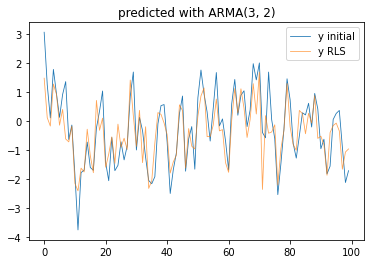

In [22]:
plt.plot(y, label = 'y initial', lw = 0.8)
plt.plot(y_RLS, label = 'y RLS', lw = 0.8, alpha = 0.7)
plt.title('predicted with ARMA' + f'{ARMA}')
plt.legend()